## dataload & FeatureEngineering

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')

def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # 유저별 문제푼 시간 Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    
    ## big_category
    # big_category 전체 정답률, 표준편차
#     big_category_answermean = dict(df2.groupby("big_category").answerCode.mean())
#     big_category_answerstd = dict(df2.groupby("big_category").answerCode.std())
#     df2['big_category_acc'] = df2.big_category.map(big_category_answermean)
#     df2['big_category_std'] = df2.big_category.map(big_category_answerstd)

    # 유저별 big category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['big_category_cumconut'] = df2.groupby(['userID','big_category']).answerCode.cumcount()
    df2['big_category_answer'] = df2.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['big_category_user_cum_acc'] = (df2['big_category_answer'] / df2['big_category_cumconut']).fillna(0)
    
    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_big_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.mean().reset_index()
#     df2_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans,on=['userID','big_category'])
    
#     df2_user_big_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.std().reset_index()
#     df2_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans_std,on=['userID','big_category'])   
    
    ## mid_category
    # mid_category 전체 정답률, 표준편차
#     mid_category_answermean = dict(df2.groupby("mid_category").answerCode.mean())
#     mid_category_answerstd = dict(df2.groupby("mid_category").answerCode.std())
#     df2['mid_category_acc'] = df2.mid_category.map(mid_category_answermean)
#     df2['mid_category_std'] = df2.mid_category.map(mid_category_answerstd)

    # 유저별 mid category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['mid_category_cumconut'] = df2.groupby(['userID','mid_category']).answerCode.cumcount()
    df2['mid_category_answer'] = df2.groupby(['userID','mid_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['mid_category_user_cum_acc'] = (df2['mid_category_answer'] / df2['mid_category_cumconut']).fillna(0)

    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_mid_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.mean().reset_index()
#     df2_user_mid_ans.rename(columns={'answerCode':'mid_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans,on=['userID','mid_category'])

#     df2_user_mid_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.std().reset_index()
#     df2_user_mid_ans_std.rename(columns={'answerCode':'mid_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans_std,on=['userID','mid_category']) 


    ### 문항별 난이도
    ass_acc_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.mean())
    df2['ass_acc_mean'] = df2.assessmentItemID.map(ass_acc_dict)
    df2['ass_difficulty'] = 1 - df2['ass_acc_mean']
    
    ass_acc_std_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.std())
    df2['ass_acc_std'] = df2.assessmentItemID.map(ass_acc_std_dict)

    ### 문제 번호별 난이도
    pb_num_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.mean())
    df2['pb_num_acc_mean'] = df2.problem_num.map(pb_num_dict)
    df2['pb_num_difficulty'] = 1 - df2['pb_num_acc_mean']
    
    pb_num_std_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.std())
    df2['pb_num_acc_std'] = df2.problem_num.map(pb_num_std_dict)
    
    
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)
df2=df.copy()

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526700 entries, 0 to 2526699
Data columns (total 45 columns):
 #   Column                     Dtype          
---  ------                     -----          
 0   userID                     int64          
 1   assessmentItemID           object         
 2   testId                     object         
 3   answerCode                 int64          
 4   Timestamp                  object         
 5   KnowledgeTag               int64          
 6   kind                       object         
 7   uidIdx                     int64          
 8   assIdx                     int64          
 9   testIdx                    int64          
 10  user_correct_answer        float64        
 11  user_total_answer          int64          
 12  user_acc                   float64        
 13  month                      int64          
 14  day                        int64          
 15  hour                       int64          
 16  dayname           

### user의 Tag에 대한 정답률

In [16]:
df2_user_tag_acc_df = df2[df2.answerCode!=-1].groupby(['userID','KnowledgeTag']).answerCode.mean().reset_index()
df2 = df2.merge(df2_user_tag_acc_df.rename(columns={'answerCode':'user_tag_acc_mean'}), on=['userID','KnowledgeTag'], how='left')

In [27]:
df2['user_tag_difficulty'] = 1 - df2.user_tag_acc_mean

### user의 Pbnum에 대한 정답률

In [24]:
df2_user_pbnum_acc_df = df2[df2.answerCode!=-1].groupby(['userID','problem_num']).answerCode.mean().reset_index()
df2 = df2.merge(df2_user_pbnum_acc_df.rename(columns={'answerCode':'user_pbnum_acc_mean'}), on=['userID','problem_num'], how='left')

In [28]:
df2['user_pbnum_difficulty'] = 1 - df2.user_pbnum_acc_mean

In [29]:
df2.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'user_tag_acc_mean', 'user_pbnum_acc_mean', 'user_tag_difficulty',
       'user_pbnum_difficulty'],
      dtype='object')

In [3]:
cond1 = df2.kind=='test'
cond2 = df2.userID != df2.userID.shift(-5)

In [108]:
base = ['userID', 'assessmentItemID', 'answerCode', 'Timestamp','KnowledgeTag']
add_features = ['user_tag_acc_mean','user_tag_difficulty','user_pbnum_acc_mean','user_pbnum_difficulty']
cols = base + add_features
df2[cond1 & cond2][cols]

,userID,assessmentItemID,answerCode,Timestamp,KnowledgeTag,user_tag_acc_mean,user_tag_difficulty,user_pbnum_acc_mean,user_pbnum_difficulty
2985,3,A050133004,1,2020-10-26 13:12:11,5289,0.818182,0.181818,0.731250,0.268750
2986,3,A050133005,1,2020-10-26 13:12:36,5288,0.700000,0.300000,0.601266,0.398734
2987,3,A050133006,1,2020-10-26 13:12:52,5288,0.700000,0.300000,0.604651,0.395349
2988,3,A050133007,0,2020-10-26 13:13:11,5289,0.818182,0.181818,0.490196,0.509804
2989,3,A050133008,-1,2020-10-26 13:13:57,5289,0.818182,0.181818,0.500000,0.500000
3656,4,A070146004,1,2020-12-27 02:46:11,9079,1.000000,0.000000,0.663366,0.336634
3657,4,A070146005,1,2020-12-27 02:46:36,9079,1.000000,0.000000,0.643564,0.356436
3658,4,A070146006,1,2020-12-27 02:46:51,9079,1.000000,0.000000,0.714286,0.285714
3659,4,A070146007,1,2020-12-27 02:47:31,9080,0.666667,0.333333,0.717949,0.282051
3660,4,A070146008,-1,2020-12-27 02:47:54,9080,0.666667,0.333333,0.555556,0.444444


In [37]:
!ls ../LGBM/output/12_0[45]*

../LGBM/output/12_04_Sun_LGBM_ass_acc_mean_추가_피처_29개.csv
../LGBM/output/12_04_Sun_LGBM_rolling10_mean_acc_train_valid_valid_test로_나누기_피처_29개.csv
../LGBM/output/12_04_Sun_LGBM_rolling10_mean_acc_과적합_방지2_피처_29개.csv
../LGBM/output/12_04_Sun_LGBM_rolling3_mean_acc_추가_피처_29개.csv
../LGBM/output/12_05_Mon_LGBM_ass_acc_std_추가_피처_30개.csv
../LGBM/output/12_05_Mon_LGBM_ass_acc_std_추가_피처_31개.csv
../LGBM/output/12_05_Mon_LGBM_ass_acc_std_추가_피처_32개.csv
../LGBM/output/12_05_Mon_LGBM_ass_difficulty_추가_피처_29개.csv
../LGBM/output/12_05_Mon_LGBM_know_tag_difficulty_추가_피처_31개.csv
../LGBM/output/12_05_Mon_LGBM_pb_num_acc_mean_추가_피처_30개.csv
../LGBM/output/12_05_Mon_LGBM_pb_num_acc_std_추가_피처_31개.csv
../LGBM/output/12_05_Mon_LGBM_pb_num_difficulty_추가_피처_30개.csv
../LGBM/output/12_05_Mon_LGBM_test_std_tag_std_제거_피처_28개.csv
../LGBM/output/12_05_Mon_LGBM_user_tag_acc_mean_추가_피처_31개.csv
../LGBM/output/12_05_Mon_LGBM_user_tag_difficulty_추가_피처_32개.csv


In [44]:
auc677 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_user_tag_acc_mean_추가_피처_31개.csv')
auc819 = pd.read_csv('../LGBM/output/12_04_Sun_LGBM_ass_acc_mean_추가_피처_29개.csv')

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

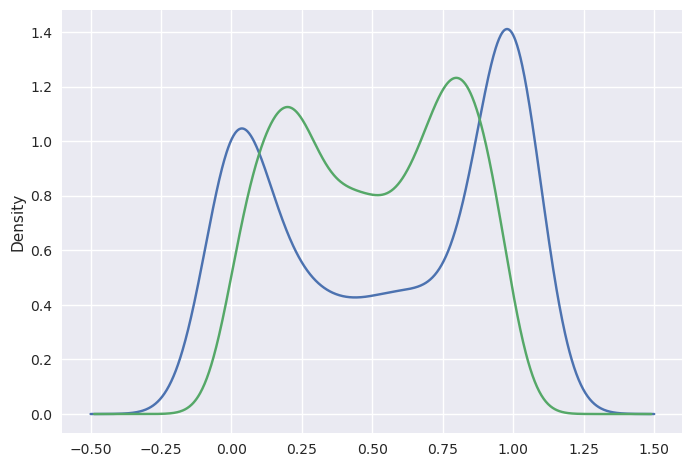

In [43]:
auc677.prediction.plot(kind='kde')
auc819.prediction.plot(kind='kde')

In [131]:
bins=70

<AxesSubplot:xlabel='bins'>

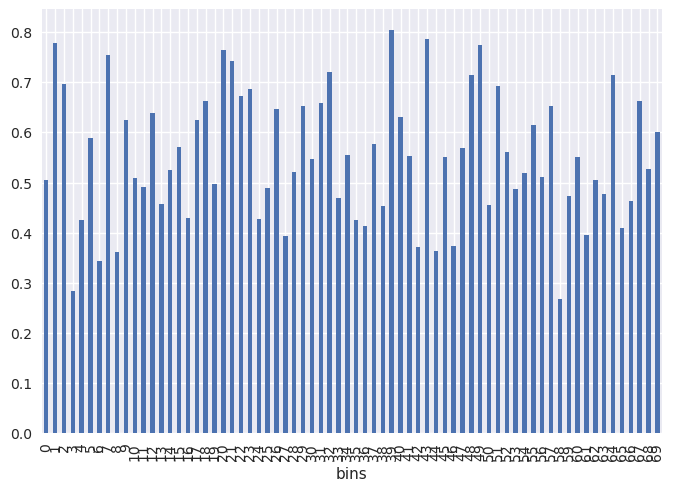

In [132]:
auc677['bins'] = pd.cut(auc677.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc677.bins.unique()))}
auc677['bins'] = auc677.bins.map(bins_map)
auc677_grp = auc677.groupby('bins').prediction.mean()
auc677_grp.plot(kind='bar')

<AxesSubplot:xlabel='bins'>

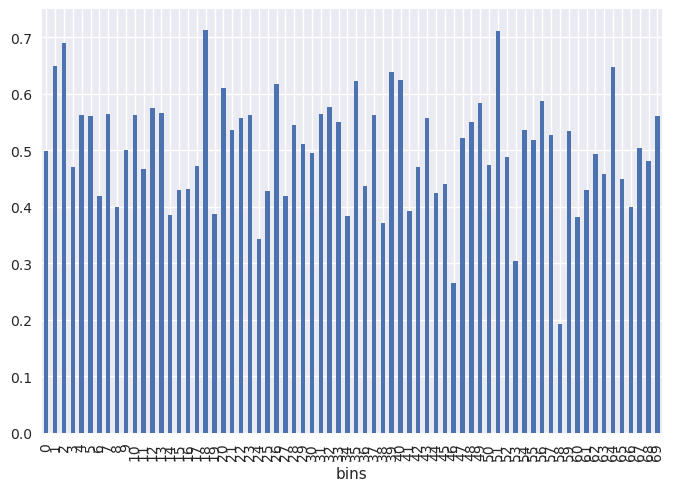

In [133]:
auc819['bins'] = pd.cut(auc819.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc819.bins.unique()))}
auc819['bins'] = auc819.bins.map(bins_map)
auc819_grp = auc819.groupby('bins').prediction.mean()
auc819_grp.plot(kind='bar')

<AxesSubplot:xlabel='bins'>

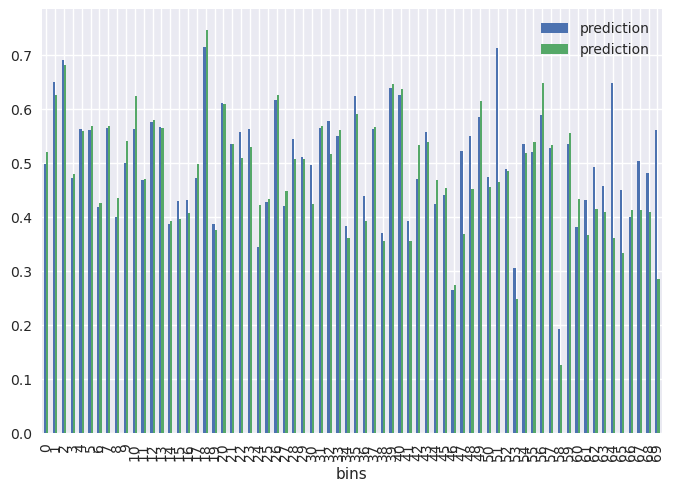

In [134]:
# 0.7781
user_dfc = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_user_pbnum_acc_mean만_추가_피처_31개.csv')
user_dfc['bins'] = pd.cut(user_dfc.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc.bins.unique()))}
user_dfc['bins'] = user_dfc.bins.map(bins_map)
user_dfc_grp = user_dfc.groupby('bins').prediction.mean()
pd.concat([auc819_grp,user_dfc_grp],axis=1).plot(kind='bar')

<AxesSubplot:xlabel='bins'>

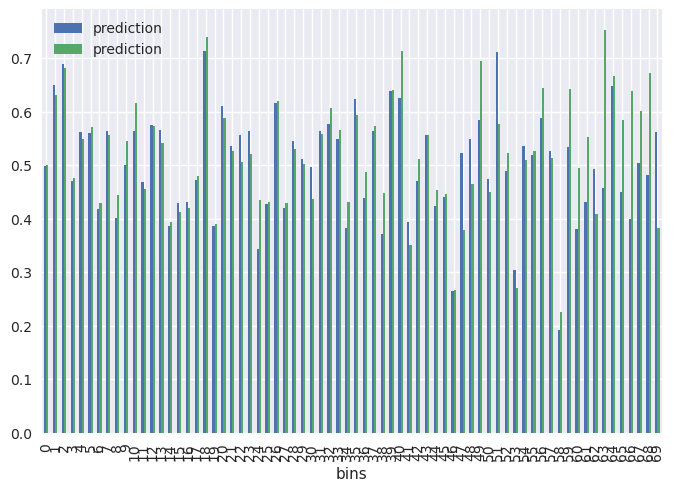

In [140]:
user_dfc2 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_user_pbnum_difficulty만_추가_피처_31개.csv')
user_dfc2['bins'] = pd.cut(user_dfc2.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc2.bins.unique()))}
user_dfc2['bins'] = user_dfc2.bins.map(bins_map)
user_dfc2_grp = user_dfc2.groupby('bins').prediction.mean()
pd.concat([auc819_grp,user_dfc2_grp],axis=1).plot(kind='bar')

<AxesSubplot:xlabel='bins'>

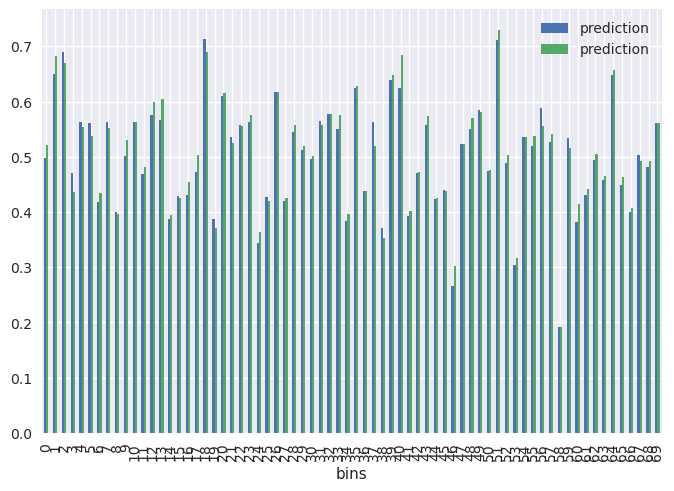

In [138]:
auc816 = pd.read_csv('../LGBM/output/12_03_Sat_LGBM_rolling3_mean_auc_추가_피처_28개.csv')
auc816['bins'] = pd.cut(auc816.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc816.bins.unique()))}
auc816['bins'] = auc816.bins.map(bins_map)
auc816_grp = auc816.groupby('bins').prediction.mean()
pd.concat([auc819_grp,auc816_grp],axis=1).plot(kind='bar')

<AxesSubplot:xlabel='bins'>

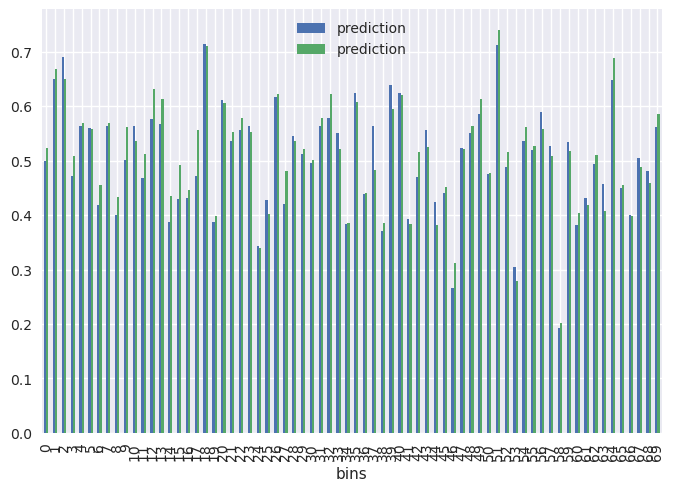

In [139]:
auc815 = pd.read_csv('../LGBM/output/11_30_Wed_LGBM_big_category_정답률_std_cumcount_추가_earlystop_피처_27개.csv')
auc815['bins'] = pd.cut(auc815.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc815.bins.unique()))}
auc815['bins'] = auc815.bins.map(bins_map)
auc815_grp = auc815.groupby('bins').prediction.mean()
pd.concat([auc819_grp,auc815_grp],axis=1).plot(kind='bar')

<AxesSubplot:xlabel='bins'>

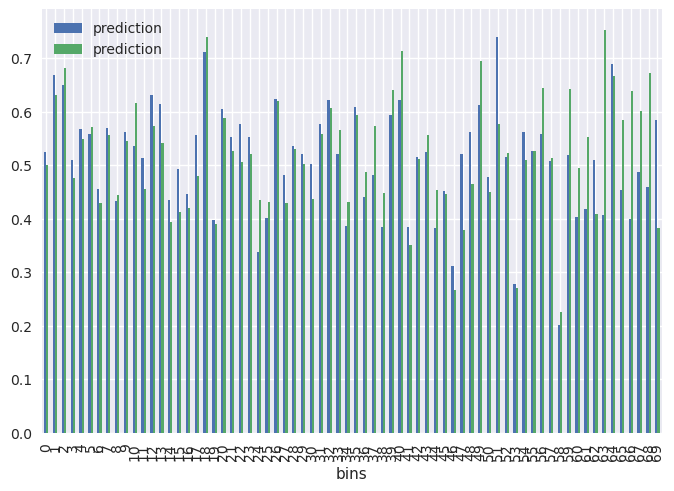

In [143]:
auc815 = pd.read_csv('../LGBM/output/11_30_Wed_LGBM_big_category_정답률_std_cumcount_추가_earlystop_피처_27개.csv')
auc815['bins'] = pd.cut(auc815.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc815.bins.unique()))}
auc815['bins'] = auc815.bins.map(bins_map)
auc815_grp = auc815.groupby('bins').prediction.mean()
pd.concat([auc815_grp,user_dfc2_grp],axis=1).plot(kind='bar')

<AxesSubplot:xlabel='bins'>

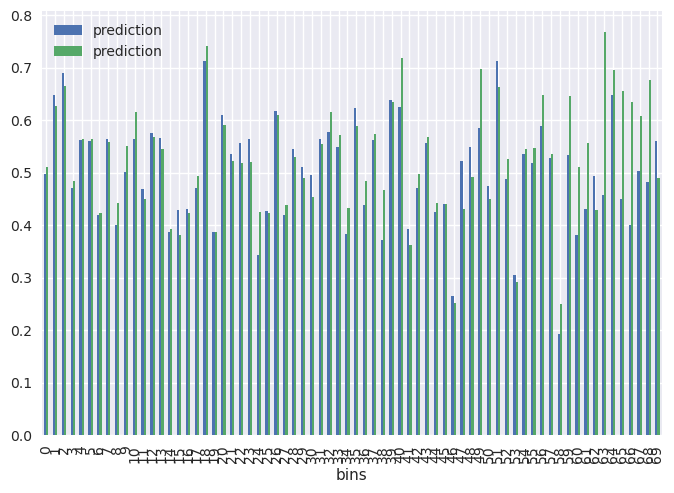

In [144]:
user_dfc2 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_user_pbnum_difficulty만_추가_피처_31개.csv')
user_dfc2['bins'] = pd.cut(user_dfc2.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc2.bins.unique()))}
user_dfc2['bins'] = user_dfc2.bins.map(bins_map)
user_dfc2_grp = user_dfc2.groupby('bins').prediction.mean()
pd.concat([auc819_grp,user_dfc2_grp],axis=1).plot(kind='bar')

In [90]:
cmpare = auc677.merge(auc819[['id','prediction']], on='id', how='left')

In [92]:
cmpare[cmpare.bins==1]

,id,prediction_x,bins,prediction_y
15,15,0.999975,1,0.969901
16,16,0.236154,1,0.174977
17,17,0.999953,1,0.899236
18,18,0.930843,1,0.912565
19,19,0.173552,1,0.158275
20,20,0.916543,1,0.931588
21,21,0.303487,1,0.735863
22,22,0.000015,1,0.646890
23,23,0.000014,1,0.320236
24,24,0.365948,1,0.243485


In [97]:
uid2id_dict = {k:v for v,k in enumerate(sorted(df[df.kind=='test'].userID.unique()))}

In [103]:
df2['id'] = df2.userID.map(uid2id_dict)

In [105]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [113]:
df2.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'user_tag_acc_mean', 'user_pbnum_acc_mean', 'user_tag_difficulty',
       'user_pbnum_difficulty', 'id'],
      dtype='object')

In [114]:
base = ['userID', 'assessmentItemID', 'answerCode', 'Timestamp','KnowledgeTag']
add_features = ['user_tag_acc_mean','user_pbnum_acc_mean','id']
cols = base + add_features
df2[(df2.id==21)&(df2.KnowledgeTag==2111)][cols]

,userID,assessmentItemID,answerCode,Timestamp,KnowledgeTag,user_tag_acc_mean,user_pbnum_acc_mean,id
188766,226,A040155001,0,2020-07-24 04:35:01,2111,0.5,0.815789,21.0
188767,226,A040155002,1,2020-07-24 04:35:49,2111,0.5,0.710526,21.0
188768,226,A040155003,0,2020-07-24 04:35:55,2111,0.5,0.710526,21.0
188769,226,A040155004,0,2020-07-24 04:36:08,2111,0.5,0.675676,21.0
188770,226,A040155005,0,2020-07-24 04:36:39,2111,0.5,0.545455,21.0
188771,226,A040155006,0,2020-07-24 04:36:56,2111,0.5,0.700000,21.0
188883,226,A040142001,1,2020-10-26 11:16:36,2111,0.5,0.815789,21.0
188884,226,A040142002,1,2020-10-26 11:18:22,2111,0.5,0.710526,21.0
188885,226,A040142003,1,2020-10-26 11:18:34,2111,0.5,0.710526,21.0
188886,226,A040142004,1,2020-10-26 11:21:17,2111,0.5,0.675676,21.0


<AxesSubplot:xlabel='bins'>

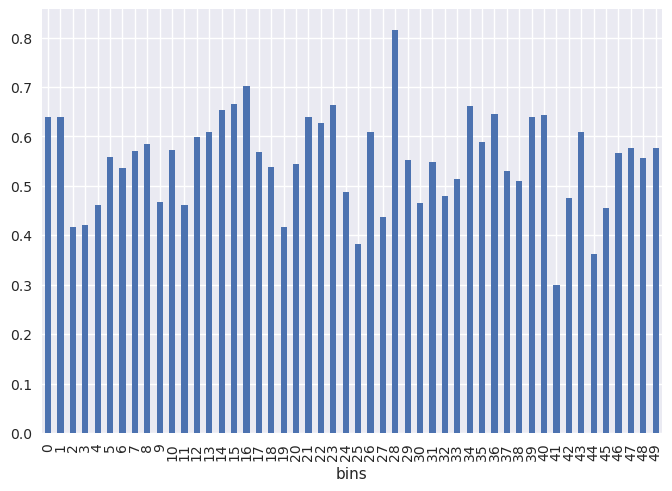

In [87]:
user_dfcty1 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_user_tag_difficulty_추가_피처_32개.csv')
user_dfcty1['bins'] = pd.cut(user_dfcty1.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfcty1.bins.unique()))}
user_dfcty1['bins'] = user_dfcty1.bins.map(bins_map)
user_dfcty1_grp = user_dfcty1.groupby('bins').prediction.mean()
user_dfcty1_grp.plot(kind='bar')

<AxesSubplot:xlabel='bins'>

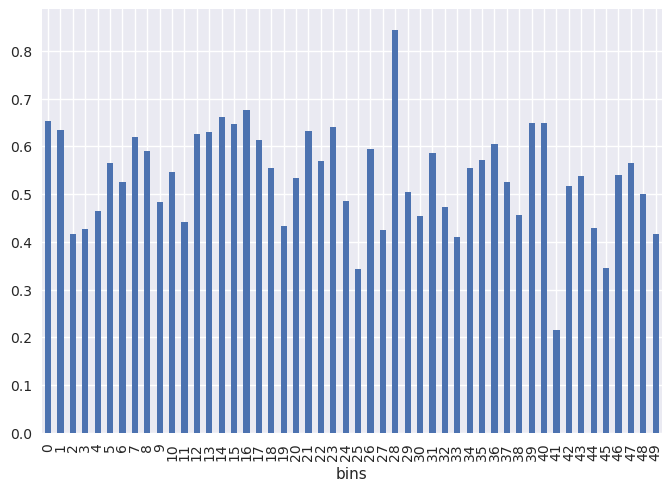

In [115]:
user_dfc2 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_user_pbnum_acc_mean_추가_피처_33개.csv')
user_dfc2['bins'] = pd.cut(user_dfc2.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc2.bins.unique()))}
user_dfc2['bins'] = user_dfc2.bins.map(bins_map)
user_dfc2_grp = user_dfc2.groupby('bins').prediction.mean()
user_dfc2_grp.plot(kind='bar')

## 내보내기

In [31]:
df2.sort_values(by=['userID','Timestamp'], inplace=True)

In [32]:
export(df2, output='lgbm_user_acc_difficulty.pkl')

Write: /opt/ml/input/data/lgbm_user_acc_difficulty.pkl
